In [1]:
import sys
sys.path.append('../src/')
import decode_mcd
import decode_mcd.multi_objective_problem as MOP
from decode_mcd import data_package


from decode_mcd import design_targets
from decode_mcd import counterfactuals_generator

import numpy as np
import matplotlib.pyplot as plt

### Creating a random dataset

First, let's create a toy dataset for testing. Our design variables will just be two randomized variables ranging from 0 to 1. We'll generate 10 toy datapoints. We call this the `features_dataset`

In [2]:
np.random.seed(0) #set random seed to make this notebook repeatable
x = np.random.random((10,2))
print(x)

[[0.5488135  0.71518937]
 [0.60276338 0.54488318]
 [0.4236548  0.64589411]
 [0.43758721 0.891773  ]
 [0.96366276 0.38344152]
 [0.79172504 0.52889492]
 [0.56804456 0.92559664]
 [0.07103606 0.0871293 ]
 [0.0202184  0.83261985]
 [0.77815675 0.87001215]]


Now, let's create design evaluation function, `evaluate()`. We'll say that our quantity of interest is just the sum of the two design variables.

In [3]:
def evaluate(x): 
    #MCD uses pandas dataframes internally. More in this in the next notebook. 
    x = np.array(x)  #For now, we convert to numpy for simplicity, in the event x is a different type.
    y = x[:,0] + x[:,1]
    y = y.reshape(-1,1) #reshaping here is important. We need to return a 2D array. 
    return y

Finally, we'll evaluate the designs in the dataset. We call these the `predictions_dataset`, as the evaluator is often an ML model

In [4]:
y = evaluate(x)
print(y)

[[1.26400287]
 [1.14764656]
 [1.06954891]
 [1.32936021]
 [1.34710428]
 [1.32061996]
 [1.4936412 ]
 [0.15816536]
 [0.85283824]
 [1.6481689 ]]


Finally, lets create a design as our query, which we call `query_x`. Note that `query_x` is a 2D array. This is design that we would like MCD to modify.

In [5]:
x_query = np.array([[0.3, 0.2]])
y_query = evaluate(x_query)

Great! Let's plot what we've got. We will make a scatterplot of the dataset and the query and color-code the values based on objective value

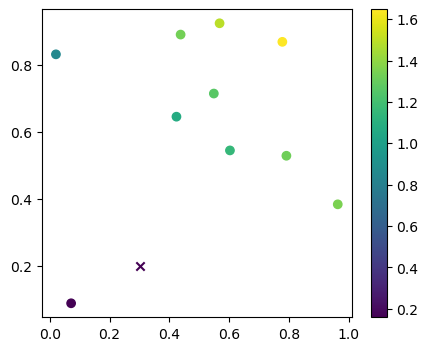

In [6]:
plt.figure(figsize=(5,4))
plt.scatter(x[:,0], x[:,1], c=y, marker='o')
plt.colorbar() 
plt.scatter(x_query[:,0], x_query[:,1], c=y_query, marker='x') 

### Creating MCD DataPackage

Now, we create an instance of a MCD `DataPackage`. The `DataPackage` requires the design dataset (`x`), the evaluated objective values (`y`), and the design `x_datatypes`. Here's how to set the 'x_datatypes' object. In our case, this is just two Real types.

In [7]:
from pymoo.core.variable import Real
datatypes=[Real(bounds=(0, 1)),Real(bounds=(0, 1))]

Finally, we create the `DataPackage`.

In [8]:
data = data_package.DataPackage(x=x, y=y, x_datatypes=datatypes)

### Creating MCD MultiObjectiveProblem

Next, we set up the MCD `MultiObjectiveProblem` instance, which takes in the `DataPackage` we just created, as well as our query, 'query_x', our evaluation function.

The design targets are a list of individual targets. Each target will contain an index telling MCD which column of the evaluator's output it is constraining. Since our example only has one, we specify index 0. Different types of design targets have different arguments. In our case, we are specifying a `ContinuousTarget` that the x0 + x1 must be between 1 and 1.5. The following notebook discusses how to set up multiple design targets including a `CategoricalTarget`. 

In [9]:
target_1 = design_targets.ContinuousTarget(label = 0, lower_bound=1, upper_bound=1.5)
y_targets = design_targets.DesignTargets(continuous_targets=[target_1])

In [10]:
problem = MOP.MultiObjectiveProblem(data_package=data, x_query = x_query, y_targets = y_targets, prediction_function=evaluate)

### Creating MCD CounterfactualsGenerator

Finally, we create an instance of MCD's `CounterfactualsGenerator`. We pass in the `MultiObjectiveProblem` we just created, as well as a population size for the optimization. It also takes an optional argument specifying whether or not to initialize the search from the designs in the specified dataset (default is True)

In [11]:
generator = counterfactuals_generator.CounterfactualsGenerator(problem=problem, pop_size=100, initialize_from_dataset=True)

### Generating and Sampling Counterfactuals

MCD suggests counterfactuals in two stages. The first is the "Discovery" phase where MCD performs design optimization while retaining all design candidates considered. We simply call the `generate` function of the `CounterfactualsGenerator` instance we just created. 

In [12]:
generator.generate(n_generations=10)

10 dataset entries found matching problem parameters
Initial population initialized from dataset of 10 samples!
Training GA from 0 to 10 generations!
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        0 |      4 |  0.000000E+00 |  0.1488332089 |             - |             -
     2 |      100 |     13 |  0.000000E+00 |  0.0900685564 |  1.0000000000 |         ideal
     3 |      200 |     15 |  0.000000E+00 |  0.000000E+00 |  0.0235646463 |             f
     4 |      300 |     22 |  0.000000E+00 |  0.000000E+00 |  0.0075783599 |             f
     5 |      400 |     34 |  0.000000E+00 |  0.000000E+00 |  0.0358711701 |         ideal
     6 |      500 |     38 |  0.000000E+00 |  0.000000E+00 |  0.0014323291 |             f
     7 |      600 |     51 |  0.000000E+00 |  0.000000E+00 |  0.0053016510 |             f
     8 |      700 |     76 |  0.000000E+00 |  0.000000E+00 |  0.0036069368 |             f
     9 |      800 |     87 |  0

The second stage is sampling a diverse set of counterfactuals from all the possibilities discovered. MCD's `CounterfactualsGenerator` class includes a few functions to do this, but the simplest is the `sample_with_weights`. The first thing we specify is the number of samples we want. Next we include a few counterfactual quality objective weights (more in this in Notebook 3). Finally, we have an option to sample designs directly from the given dataset (assuming they are strong counterfactuals). 

In [18]:
num_samples = 10 
counterfactuals = generator.sample(num_samples, include_dataset=False)

Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
samples_index=[466, 251, 394, 237, 100, 382, 97, 259, 448, 439]
Done! Returning CFs


Let's have a look at our counterfactuals. 

In [19]:
counterfactuals = np.array(counterfactuals) #convert to numpy array for plotting
print(counterfactuals)

[[0.80864132 0.2       ]
 [0.3        0.70409907]
 [0.54762295 0.46309828]
 [0.3        0.82841636]
 [0.97798705 0.2       ]
 [0.3        0.74636937]
 [0.86110911 0.2       ]
 [0.3        0.98684272]
 [0.3        0.72650097]
 [0.3576159  0.64933948]]


Now, lets repeat our plot from earlier, but add the generated counterfactuals. We also add the objective ranges as dotted lines. We see that the generated counterfactuals (+) fall within the designated boundaries. While they are diverse, a number of them lie near the lower boundary, attempting to be as proximal to the query as possible.

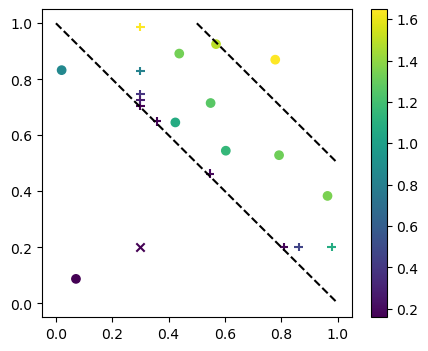

In [20]:
cf_y = evaluate(counterfactuals)

plt.figure(figsize=(5,4))
plt.scatter(x[:,0], x[:,1], c=y, marker='o')
plt.colorbar() 
plt.scatter(counterfactuals[:,0], counterfactuals[:,1], c=cf_y, marker='+')
plt.scatter(x_query[:,0], x_query[:,1], c=y_query, marker='x') 

plt.plot([0,1], [1,0], 'k--')
plt.plot([0.5,1], [1,0.5], 'k--')

This concludes the first MCD tutorial notebook! In the next we will cover mixed datatypes, and generating counterfactuals with multiple mixed objectives types. 